In [1]:
import numpy as np
import cupy as cp
from holotomocupy.shift import ST
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
import h5py

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension
pad = n//8
npos= 18*18
z1c = -20.1e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = 6144+2*pad
show = True

flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'
post = f''
print(voxelsize)

4.769839921875e-08


## Read data

In [3]:
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/code2um_nfp18x18_010000.h5') as fid:
    data0 = fid['/entry_0000/measurement/data'][:].astype('float32')
    
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/ref_0000.h5') as fid:
    ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/dark_0000.h5') as fid:
    dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')

data0 = data0[np.newaxis]
shifts_code0 = np.loadtxt(f'/data/vnikitin/ESRF/ID16A/20240924/positions/shifts_code_nfp18x18ordered.txt')[np.newaxis,:,::-1]
shifts_code0 = shifts_code0/voxelsize*1e-6
print(shifts_code0[:,:10])


[[[-2096.5064161  -2253.74439731]
  [-2096.5064161  -1834.44311409]
  [-2148.91907651 -1729.61779329]
  [-2253.74439731 -1310.31651007]
  [-2253.74439731 -1257.90384966]
  [-2096.5064161   -733.77724564]
  [-2253.74439731  -628.95192483]
  [-2044.0937557   -314.47596242]
  [-2096.5064161   -157.23798121]
  [-2044.0937557    157.23798121]]]


In [4]:
data = data0.copy()
ref = ref0.copy()
dark = dark0.copy()
for k in range(npos):
    radius = 7
    threshold = 20000
    data[:,k] = remove_outliers(data[:,k], radius, threshold)
ref[:] = remove_outliers(ref[:], radius, threshold)     
dark[:] = remove_outliers(dark[:], radius, threshold)     

# data[data<=0] = 0
# ref[ref<=0] = 0

data/=np.mean(ref)
dark/=np.mean(ref)
ref/=np.mean(ref)

rdata0 = (data-np.mean(dark,axis=0))/(np.mean(ref,axis=0)-np.mean(dark,axis=0))

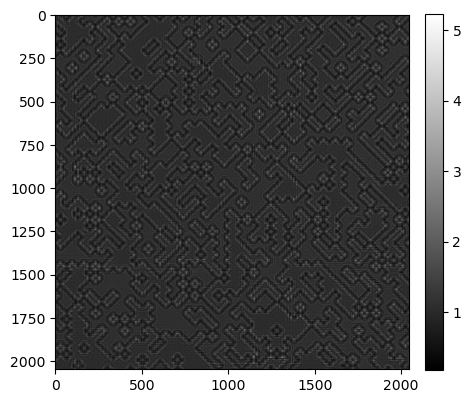

In [5]:
mshow(rdata0[0,0],show)

In [6]:
print(rdata0.shape,shifts_code0.shape)
np.save('rdata',rdata0[0,:19])
np.save('shifts_code',shifts_code0[0,:19])


(1, 324, 2048, 2048) (1, 324, 2)


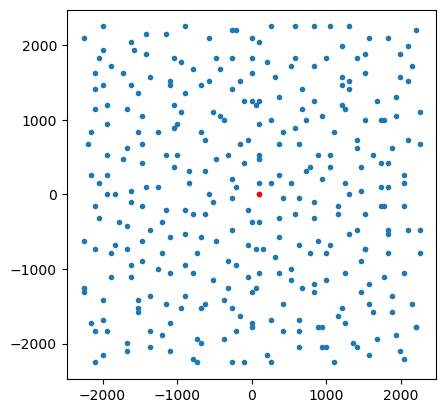

In [7]:
ipos = npos//2+9
plt.plot(shifts_code0[0,:,0],shifts_code0[0,:,1],'.')
plt.plot(shifts_code0[0,ipos,0],shifts_code0[0,ipos,1],'r.')

plt.axis('square')
plt.show()

In [8]:
rdata = rdata0.copy()
shifts_code = shifts_code0.copy()
shifts_code[:,:,0] *= -1

shifts_relative = shifts_code*0    
frame = 10
zoom = 100

def my_phase_corr(d1, d2):
    image_product = np.fft.fft2(d1) * np.fft.fft2(d2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ind = np.unravel_index(np.argmax(cc_image.real, axis=None), cc_image.real.shape)
    shifts = np.subtract(ind,d1.shape[-1]//2) 
    return shifts

rdata = rdata0.copy()
for k in range(0,npos-1):         
    shifts_relative[0,k]=my_phase_corr(rdata[0,k],rdata[0,k+1])
    print(k,shifts_relative[0,k])
    rdata[:,k] = ST(rdata[:,k],shifts_relative[:,k])
np.save('shifts_relative',shifts_relative)    


0 [ -6. 434.]


/tmp/ipykernel_1776405/1609107663.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  rdata[:,k] = ST(rdata[:,k],shifts_relative[:,k])


1 [ 54. 125.]
2 [113. 468.]
3 [ 0. 55.]
4 [-121.  450.]
5 [121. 244.]
6 [-176.  211.]
7 [ 23. 254.]
8 [-24. 270.]
9 [ 68. 233.]
10 [ 52. 484.]
11 [-22.  94.]
12 [-44. 313.]
13 [  1. 295.]
14 [  1. 236.]
15 [-51. 222.]
16 [175. 437.]
17 [-231.   32.]
18 [   7. -327.]
19 [-109. -251.]
20 [  69. -180.]
21 [ -23. -376.]
22 [  -1. -292.]
23 [  -2. -470.]
24 [  -1. -294.]
25 [ -99. -332.]
26 [ 65. 118.]
27 [-122. -529.]
28 [  23. -271.]
29 [ 43. -80.]
30 [  -1. -355.]
31 [ 107. -328.]
32 [  -1. -295.]
33 [ -23. -259.]
34 [  23. -268.]
35 [-290. -102.]
36 [  0. 111.]
37 [-171.  454.]
38 [  0. 176.]
39 [ 64. 462.]
40 [  1. 174.]
41 [ 52. 249.]
42 [  1. 349.]
43 [-23. 270.]
44 [  1. 175.]
45 [ 78. 564.]
46 [-23.  94.]
47 [-150.  180.]
48 [117. 485.]
49 [-23. 276.]
50 [ 78. 269.]
51 [-119.  226.]
52 [ 21. 199.]
53 [-187.   26.]
54 [   6. -269.]
55 [ -54. -365.]
56 [ 117. -109.]
57 [ -22. -432.]
58 [-209. -287.]
59 [171. -41.]
60 [  -1. -296.]
61 [ -21. -432.]
62 [  21. -215.]
63 [ -65. -467.]
64

In [ ]:
shifts_code = shifts_code0.copy()
shifts_code[:,:,0]*=-1
shifts_relative = -np.load('shifts_relative.npy')

shifts_code_new = shifts_code*0
for k in range(ipos):
    shifts_code_new[:,k] = np.sum(shifts_relative[:,k:ipos],axis=1) 
shifts_code_new[:,ipos] = shifts_code[:,ipos]
for k in range(ipos,npos):
    shifts_code_new[:,k] = np.sum(-shifts_relative[:,ipos:k],axis=1)

plt.plot(shifts_code[0,:,1],shifts_code[0,:,0],'.')
plt.plot(shifts_code_new[0,:,1],shifts_code_new[0,:,0],'.')
plt.show()

#back to original shape
shifts_code_new[:,:,0]*=-1

print(shifts_code0[:,-10:])
print(shifts_code_new[:,-10:])

np.save('shifts_code_new.npy',shifts_code_new)
